In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

In [2]:
import numpy as np
dataset_path = "dataset/dataset_0725"

X_train = np.load(f'{dataset_path}/X_train.npy')
y_train = np.load(f'{dataset_path}/y_train.npy').astype(float).flatten()
X_val = np.load(f'{dataset_path}/X_val.npy')
y_val = np.load(f'{dataset_path}/y_val.npy').astype(float).flatten()
X_test = np.load(f'{dataset_path}/X_test.npy')
y_test = np.load(f'{dataset_path}/y_test.npy').astype(float).flatten()





# lr list

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义 RNN 回归模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.1):
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy

# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
learning_rates = [ 1e-3, 1e-4]
num_epochs = 10000

results = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = RNNModel(input_dim=12, hidden_dim=128, output_dim=1, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    lowest_val_loss = float('inf')
    lowest_val_loss_epoch = 0
    best_train_accuracy = 0.0
    best_train_accuracy_epoch = 0
    lowest_train_loss = float('inf')
    lowest_train_loss_epoch = 0

    for epoch in tqdm(range(num_epochs), desc=f"Learning Rate {lr}"):
        model.train()
        running_loss = 0.0
        all_predictions_train = []
        all_labels_train = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            all_predictions_train.append(outputs)
            all_labels_train.append(labels.unsqueeze(1))
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        all_predictions_train = torch.cat(all_predictions_train, dim=0)
        all_labels_train = torch.cat(all_labels_train, dim=0)
        train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=1)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
                val_loss += loss.item() * inputs.size(0)
                
                all_predictions.append(outputs)
                all_labels.append(labels.unsqueeze(1))
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.1)
        val_accuracies.append(val_accuracy)
        
        # 记录最好的准确率和最低的损失
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_accuracy_epoch = epoch + 1
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            lowest_val_loss_epoch = epoch + 1
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_accuracy_epoch = epoch + 1
        if epoch_loss < lowest_train_loss:
            lowest_train_loss = epoch_loss
            lowest_train_loss_epoch = epoch + 1
    
    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch,
        'lowest_val_loss': lowest_val_loss,
        'lowest_val_loss_epoch': lowest_val_loss_epoch,
        'best_train_accuracy': best_train_accuracy,
        'best_train_accuracy_epoch': best_train_accuracy_epoch,
        'lowest_train_loss': lowest_train_loss,
        'lowest_train_loss_epoch': lowest_train_loss_epoch,
    }






Training with learning rate: 0.001


Learning Rate 0.001: 100%|██████████| 10000/10000 [3:35:53<00:00,  1.30s/it] 



Training with learning rate: 0.0001


Learning Rate 0.0001: 100%|██████████| 10000/10000 [4:58:20<00:00,  1.79s/it] 


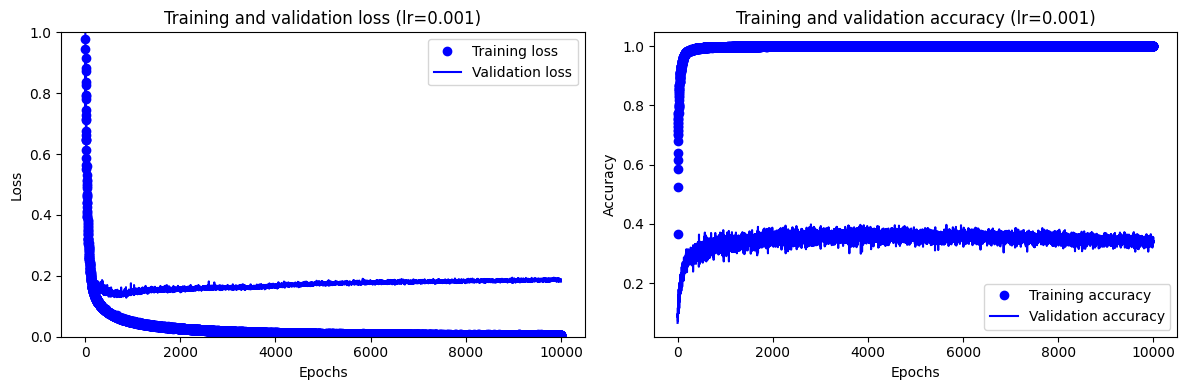

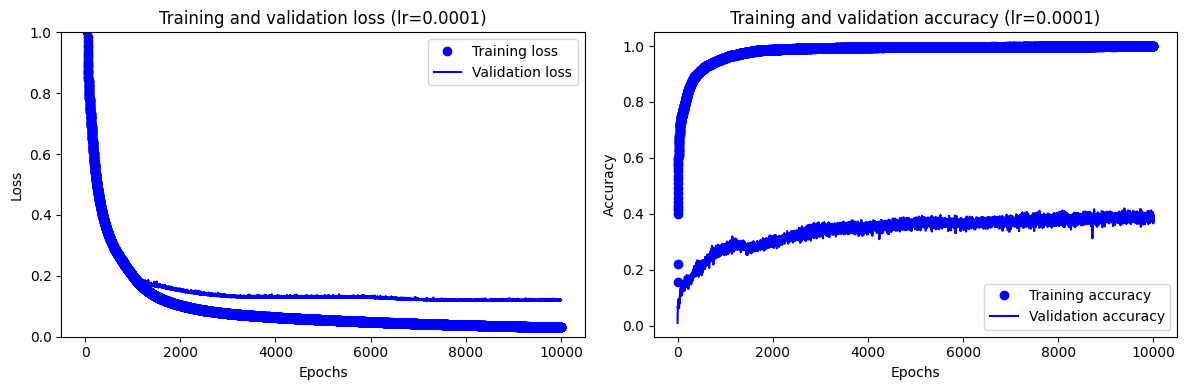

In [16]:
# 绘制图表
for lr, result in results.items():
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result['train_losses'], 'bo', label='Training loss')
    plt.plot(epochs, result['val_losses'], 'b', label='Validation loss')
    plt.title(f'Training and validation loss (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, result['train_accuracies'], 'bo', label='Training accuracy')
    plt.plot(epochs, result['val_accuracies'], 'b', label='Validation accuracy')
    plt.title(f'Training and validation accuracy (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [18]:

# 打印每个学习率的最佳结果
for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}")
    print(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}")
    print(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}")
    print(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}")
    print("\n")

Learning rate: 0.001
Best Validation Accuracy: 0.3984 at epoch 2803
Lowest Validation Loss: 0.1282 at epoch 867
Best Training Accuracy: 1.0000 at epoch 2124
Lowest Training Loss: 0.0038 at epoch 9915


Learning rate: 0.0001
Best Validation Accuracy: 0.4190 at epoch 9390
Lowest Validation Loss: 0.1169 at epoch 8571
Best Training Accuracy: 0.9997 at epoch 9740
Lowest Training Loss: 0.0304 at epoch 9997




In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义模型
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleMLP(input_dim=12)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 记录损失和准确率
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
lowest_val_loss = float('inf')
best_train_accuracy = 0.0
lowest_train_loss = float('inf')

best_val_accuracy_epoch = 0
lowest_val_loss_epoch = 0
best_train_accuracy_epoch = 0
lowest_train_loss_epoch = 0

# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.1):
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy

# 训练模型
num_epochs = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()
    running_loss = 0.0
    all_predictions_train = []
    all_labels_train = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        all_predictions_train.append(outputs)
        all_labels_train.append(labels.unsqueeze(1))
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    all_predictions_train = torch.cat(all_predictions_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=0.1)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            val_loss += loss.item() * inputs.size(0)
            
            all_predictions.append(outputs)
            all_labels.append(labels.unsqueeze(1))
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.1)
    val_accuracies.append(val_accuracy)
    
    # 记录最好的准确率和最低的损失
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_val_accuracy_epoch = epoch + 1
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        lowest_val_loss_epoch = epoch + 1
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        best_train_accuracy_epoch = epoch + 1
    if epoch_loss < lowest_train_loss:
        lowest_train_loss = epoch_loss
        lowest_train_loss_epoch = epoch + 1
    
    # 在每个 epoch 结束时打印日志
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# 测试模型
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_predictions_test = []
all_labels_test = []
with torch.no_grad():
    with tqdm(total=len(test_loader), desc='Testing', unit='batch') as pbar:
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * inputs.size(0)
            
            all_predictions_test.append(outputs)
            all_labels_test.append(labels.unsqueeze(1))
            pbar.update(1)

test_loss /= len(test_loader.dataset)
all_predictions_test = torch.cat(all_predictions_test, dim=0)
all_labels_test = torch.cat(all_labels_test, dim=0)
test_accuracy = calculate_custom_accuracy(all_predictions_test, all_labels_test, tolerance=0.1)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# 绘制损失和准确率图
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epochs:   1%|▏         | 26/2000 [00:05<07:06,  4.62it/s]


KeyboardInterrupt: 

In [5]:
# 打印最好的准确率和最低的损失及其对应的 epoch
print(f'Best Training Accuracy: {best_train_accuracy:.4f} at epoch {best_train_accuracy_epoch}')
print(f'Lowest Training Loss: {lowest_train_loss:.4f} at epoch {lowest_train_loss_epoch}')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_val_accuracy_epoch}')
print(f'Lowest Validation Loss: {lowest_val_loss:.4f} at epoch {lowest_val_loss_epoch}')

Best Training Accuracy: 0.2019 at epoch 985
Lowest Training Loss: 0.3810 at epoch 990
Best Validation Accuracy: 0.2212 at epoch 959
Lowest Validation Loss: 0.3770 at epoch 996
